In [1]:
import numpy as np
import pandas as pd

In [2]:
import json
import re
import requests

import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import f1_score
from IPython.core.display import HTML, display

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilalevuskin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
train_df = pd.read_csv("train.csv")

train_df.head()

,id,url,title,target
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",False
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,False
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,False
3,3,colorbox.spb.ru,Не Беси Меня Картинки,False
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,False


In [4]:
train_df.isnull().sum()

id        0
url       0
title     0
target    0
dtype: int64

In [5]:
pd.options.display.max_rows = 1000

In [6]:
test_df = pd.read_csv("test.csv")

test_df.head()

,id,url,title
0,135309,www.kommersant.ru,Шестой кассационный суд в Самаре начнет работу...
1,135310,urexpert.online,"Что такое индексация алиментов, кем и в каких ..."
2,135311,imperimeha.ru,Женщинам | Империя Меха - Part 12
3,135312,national-porn.com,"Небритые, волосатые киски: Порно всех стран и ..."
4,135313,2gis.ru,67


In [7]:
train_df["target"].value_counts()

False    118594
True      16715
Name: target, dtype: int64

In [8]:
from sklearn.metrics import f1_score

In [9]:
X_train = train_df["title"].values
X_test = test_df["title"].values
y_train = train_df["target"].astype(int).values

In [186]:
X_test_url = test_df["url"].values

# Simple baseline

In [10]:
y_pred = [int("порно" in text) for text in X_train]

In [11]:
f1_score(y_train, y_pred)

0.31242758551206484

### Submit

In [12]:
test_df["target"] = [("порно" in text) for text in X_test]

test_df[["id", "target"]].to_csv("simple_baseline.csv", index=False)

!cat simple_baseline.csv | head

id,target
135309,False
135310,False
135311,False
135312,False
135313,False
135314,False
135315,False
135316,False
135317,False
cat: stdout: Broken pipe


### Не все так однозначно

**не порно**:
- Болезни опорно-двигательной системы и импотенция: взаимосвязь
- Транссексуальные рыбы - National Geographic Россия: красота мира в каждом кадре
- Групповая обзорная экскурсия по Афинам - цена €50
- Больного раком Задорнова затравили в соцсетях.
- Гомосексуалисты на «Первом канале»? Эрнст и Галкин – скрытая гей-пара российского шоу-бизнеса | Заметки о стиле, моде и жизни

**порно**:
- Отборная домашка
- Сюзанна - карьера горничной / Susanna cameriera perversa (с русским переводом) 1995 г., DVDRip

# ML baseline

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

vectorizer = CountVectorizer()

model = MultinomialNB()

In [14]:
X_train_vectorized = vectorizer.fit_transform(X_train)

In [15]:
X_train_vectorized

<135309x189852 sparse matrix of type '<class 'numpy.int64'>'
	with 1202659 stored elements in Compressed Sparse Row format>

In [16]:
feature_names = np.array(vectorizer.get_feature_names())

In [17]:
id_ = 42

print(X_train[id_])

x_vector = X_train_vectorized.getrow(id_).toarray()[0]

[feature for feature in feature_names[x_vector > 0]]

Презентация на тему "Приближенное значение. Абсолютная и относительная погрешнос


['абсолютная',
 'значение',
 'на',
 'относительная',
 'погрешнос',
 'презентация',
 'приближенное',
 'тему']

In [18]:
%%time

model.fit(
    X_train_vectorized,
    y_train
)

y_pred = model.predict(
    X_train_vectorized
)

CPU times: user 76.4 ms, sys: 14.9 ms, total: 91.4 ms
Wall time: 90.1 ms


In [19]:
f1_score(y_train, y_pred)

0.9036641864382985

### Submit

In [20]:
X_test_vectorized = vectorizer.transform(X_test)

test_df["target"] = model.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("ml_baseline.csv", index=False)

!cat ml_baseline.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
cat: stdout: Broken pipe


# Data Analysis

In [21]:
url_train_df = train_df[['url', 'target']]
title_train_df = train_df[['title', 'target']]

## Отличается ли длина у порно и не порно сайтов?

In [22]:
url_len_false = url_train_df.loc[url_train_df['target']  == False, 'url'].str.len().values
url_len_true = url_train_df.loc[url_train_df['target']  == True, 'url'].str.len().values

title_len_false = title_train_df.loc[title_train_df['target']  == False, 'title'].str.len().values
title_len_true = title_train_df.loc[title_train_df['target']  == True, 'title'].str.len().values

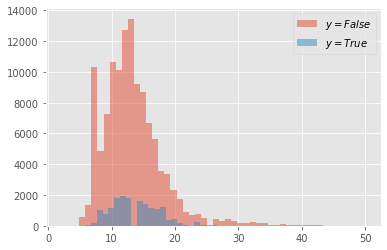

In [23]:
# Гистограмма для url
max_url_length = 50

bins=50
alpha=0.5

plt.hist(url_len_false[url_len_false <= max_url_length], alpha=alpha, bins=bins, label=r'$y = False$')
plt.hist(url_len_true[url_len_true <= max_url_length], alpha=alpha, bins=bins, label=r'$y = True$')
plt.legend();

In [24]:
np.mean(url_len_false), np.mean(url_len_true)

(13.254085366881966, 13.793239605145079)

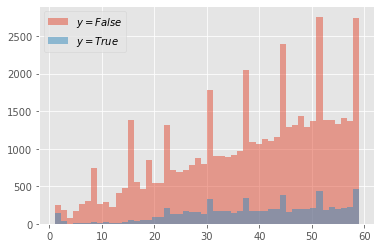

In [25]:
# Гистограмма для title
max_title_length = 59

bins=50
alpha=0.5

plt.hist(title_len_false[title_len_false <= max_title_length], alpha=alpha, bins=bins, label=r'$y = False$')
plt.hist(title_len_true[title_len_true <= max_title_length], alpha=alpha, bins=bins, label=r'$y = True$')
plt.legend();

In [26]:
np.mean(url_len_false), np.mean(url_len_true)

(13.254085366881966, 13.793239605145079)

Из распределений видно, что нет смысла вводить длину url, title как признак для решения задачи.

## Логистическая регрессия на TF-IDF

In [125]:
train, val = train_test_split(train_df, test_size=0.3, random_state=123)

In [126]:
x_train = train[['url', 'title']]
y_train = train['target']

x_val = val[['url', 'title']]
y_val = val['target']

In [127]:
url_vectorizer = TfidfVectorizer()
url_vectorizer.fit(x_train['url'])
url_x_train = url_vectorizer.transform(x_train['url'])

In [128]:
title_vectorizer = TfidfVectorizer()
title_vectorizer.fit(x_train['title'])
title_x_train = title_vectorizer.transform(x_train['title'])

In [129]:
url_x_train.shape, title_x_train.shape

((94716, 27773), (94716, 150431))

In [130]:
url_x_val = url_vectorizer.transform(x_val['url'])
title_x_val = title_vectorizer.transform(x_val['title'])

In [131]:
url_x_val.shape, title_x_val.shape

((40593, 27773), (40593, 150431))

In [132]:
LR_title = LogisticRegression(n_jobs = 4, random_state=123, multi_class = 'ovr', solver='saga', class_weight='balanced')

## title

In [133]:
LR_title.fit(title_x_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', n_jobs=4,
                   random_state=123, solver='saga')

In [135]:
y_train_pred = LR_title.predict(title_x_train)

y_train_pred_proba = LR_title.predict_proba(title_x_train)

f1_score(y_train_pred, y_train)

0.9791947439353099

In [167]:
y_val_pred = LR_title.predict(title_x_val)

y_val_pred_proba = LR_title.predict_proba(title_x_val)

f1_score(y_val_pred, y_val)

0.9364535001008675

## url

In [171]:
LR_url = LogisticRegression(n_jobs = 4, random_state=123, 
                              multi_class = 'ovr', solver='saga', class_weight='balanced')

In [172]:
LR_url.fit(url_x_train, y_train)

y_train_pred = LR_url.predict(url_x_train)

url_y_train_pred_proba = LR_url.predict_proba(url_x_train)

print(f1_score(y_train_pred, y_train))

y_val_pred = LR_url.predict(url_x_val)

url_y_val_pred_proba = LR_url.predict_proba(url_x_val)

print(f1_score(y_val_pred, y_val))

0.9303178484107579
0.8277266288951841


In [ ]:
# Видно, что url на валидационных данных сильно проигрывает title
# Сделаем sumbit для test

## submit

In [ ]:

X_test_vectorized = title_vectorizer.transform(X_test)

test_df["target"] = model.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("ml_logistic_regression_tf_idf.csv", index=False)

!cat ml_logistic_regression_tf_idf.csv | head

## RF

In [86]:
from sklearn.ensemble import RandomForestClassifier

In [87]:
RF = RandomForestClassifier(n_estimators=100)
RF.fit(title_x_train, y_train.ravel())

RandomForestClassifier()

In [88]:
RF_train = RF.predict(title_x_train)
RF_val = RF.predict(title_x_val)

In [89]:
print(f1_score(RF_train, y_train))
print(f1_score(RF_val, y_val))

0.9957414189592028
0.9480868665977249


In [90]:
X_test_vectorized = title_vectorizer.transform(X_test)

test_df["target"] = RF.predict(X_test_vectorized).astype(bool)

test_df[["id", "target"]].to_csv("ml_RF.csv", index=False)

!cat ml_RF.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
cat: stdout: Broken pipe


In [177]:
# сделаем то же самое для url
url_RF = RandomForestClassifier(n_estimators=100)
url_RF.fit(url_x_train, y_train.ravel())

url_RF_train = url_RF.predict(url_x_train)
url_RF_val = url_RF.predict(url_x_val)

print(f1_score(url_RF_train, y_train))
print(f1_score(url_RF_val, y_val))

0.9787069962726533
0.9125254910378878


## GradientBoosting

In [111]:
from sklearn.ensemble import GradientBoostingClassifier

In [112]:
boost = GradientBoostingClassifier(random_state=0)

In [113]:
boost.fit(title_x_train, y_train)

GradientBoostingClassifier(random_state=0)

In [116]:
boost_train = boost.predict(title_x_train)
boost_val = boost.predict(title_x_val)

In [117]:
print(f1_score(boost_train, y_train))
print(f1_score(boost_val, y_val))

0.8334241418594284
0.8272276057669582


In [179]:
# сделаем то же самое для url
url_boost = GradientBoostingClassifier(random_state=0)
url_boost.fit(url_x_train, y_train)

url_boost_train = url_boost.predict(url_x_train)
url_boost_val = url_boost.predict(url_x_val)

print(f1_score(url_boost_train, y_train))
print(f1_score(url_boost_val, y_val))

0.5674463701369531
0.5558921101976056


## Stacking

In [180]:
rf_proba = RF.predict_proba(title_x_train)
boost_proba = boost.predict_proba(title_x_train)

url_rf_proba = url_RF.predict_proba(url_x_train)
url_boost_proba = url_boost.predict_proba(url_x_train)

In [181]:
rf_val_proba = RF.predict_proba(title_x_val)
boost_val_proba = boost.predict_proba(title_x_val)

url_rf_val_proba = url_RF.predict_proba(url_x_val)
url_boost_val_proba = url_boost.predict_proba(url_x_val)

In [182]:
new_train = np.column_stack((rf_proba[:,1], 
                             boost_proba[:, 1], 
                             y_train_pred_proba[:, 1], 
                             url_y_train_pred_proba[:, 1],
                            url_rf_proba[:, 1],
                            url_boost_proba[:, 1]))

new_val = np.column_stack((rf_val_proba[:,1], 
                           boost_val_proba[:, 1], 
                           y_val_pred_proba[:, 1], 
                           url_y_val_pred_proba[:, 1],
                          url_rf_val_proba[:, 1],
                          url_boost_val_proba[:, 1]))

In [162]:
new_train.shape

(94716, 3)

In [183]:
LR_blend = LogisticRegression(random_state=123, multi_class = 'ovr', class_weight='balanced')
LR_blend.fit(new_train, y_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=123)

In [184]:
#train
LR_blend_train = LR_blend.predict(new_train)
print(f1_score(LR_blend_train, y_train))

0.9969447509123314


In [185]:
#val
LR_blend_val = LR_blend.predict(new_val)
print(f1_score(LR_blend_val, y_val))

0.9705023658512031


## Submit

In [187]:
X_test_vectorized = title_vectorizer.transform(X_test)
X_test_vectorized_url = url_vectorizer.transform(X_test_url)



test_rf_proba = RF.predict_proba(X_test_vectorized)
test_boost_proba = boost.predict_proba(X_test_vectorized)

test_lr_proba = LR_title.predict_proba(X_test_vectorized)
url_test_lr_proba = LR_url.predict_proba(X_test_vectorized_url)

url_test_rf_proba = url_RF.predict_proba(X_test_vectorized_url)
url_test_boost_proba = url_boost.predict_proba(X_test_vectorized_url)

new_test = np.column_stack((test_rf_proba[:,1], 
                             test_boost_proba[:, 1], 
                             test_lr_proba[:, 1], 
                             url_test_lr_proba[:, 1],
                            url_test_rf_proba[:, 1],
                            url_test_boost_proba[:, 1]))


test_df["target"] = LR_blend.predict(new_test).astype(bool)

test_df[["id", "target"]].to_csv("ml_blend.csv", index=False)

!cat ml_blend.csv | head

id,target
135309,False
135310,False
135311,False
135312,True
135313,False
135314,False
135315,False
135316,False
135317,False
cat: stdout: Broken pipe
